# Python II - Group Assignment - Electronics (Sample Dataset 1)
## An approach to detecting and understanding machine learning biases using classes

In [42]:
# Creating our classes


class bias_detection:    
    
    def create_labels(X_test,sensitive):
        sensitive_label = {}
        for i in set(X_test[sensitive]):
            text = "Num_Children" +" "+ str(i)+": "
            label = input(text)
            sensitive_label[i]=label
        return(sensitive_label)

    def representation(X_test,y_test,sensitive,labels,predictions):
        full_table = X_test.copy()
        sens_df = {}

        for i in labels:
            full_table['p'] = predictions
            full_table['t'] = y_test
            sens_df[labels[i]] = full_table[full_table[sensitive]==i]

        contigency_p = pd.crosstab(full_table[sensitive], full_table['t']) 
        cp, pp, dofp, expectedp = chi2_contingency(contigency_p) 
        contigency_pct_p = pd.crosstab(full_table[sensitive], full_table['t'], normalize='index')

        sens_rep = {}
        for i in labels:
            sens_rep[labels[i]] = (X_test[sensitive].value_counts()/X_test[sensitive].value_counts().sum())[i]

        labl_rep = {}
        for i in labels:
            labl_rep[str(i)] = (y_test.value_counts()/y_test.value_counts().sum())[i]


        fig = make_subplots(rows=1, cols=2)

        for i in labels:
            fig.add_trace(go.Bar(
            showlegend=False,
            x = [labels[i]],
            y= [sens_rep[labels[i]]]),row=1,col=1)

            fig.add_trace(go.Bar(
            showlegend=False,
            x = [str(i)],
            y= [labl_rep[str(i)]],
            marker_color=['orange','blue'][i]),row=1,col=2)

        c, p, dof, expected = chi2_contingency(contigency_p)
        cont_table = (tabulate(contigency_pct_p.T, headers=labels.values(), tablefmt='fancy_grid'))

        return cont_table, sens_df, fig, p

    def ability(sens_df,labels):
        sens_conf = {}
        for i in labels:
            sens_conf[labels[i]] = confusion_matrix(list(sens_df[labels[i]]['t']), list(sens_df[labels[i]]['p']), labels=[0,1]).ravel()

        true_positive_rate = {}
        false_positive_rate = {}
        true_negative_rate = {}
        false_negative_rate = {}

        for i in labels:
            true_positive_rate[labels[i]] = (sens_conf[labels[i]][3]/(sens_conf[labels[i]][3]+sens_conf[labels[i]][2]))
            false_positive_rate[labels[i]] = (sens_conf[labels[i]][1]/(sens_conf[labels[i]][1]+sens_conf[labels[i]][0]))
            true_negative_rate[labels[i]] = 1 - false_positive_rate[labels[i]]
            false_negative_rate[labels[i]] = 1 - true_positive_rate[labels[i]]

        return(true_positive_rate,false_positive_rate,true_negative_rate,false_negative_rate)


    def ability_plots(labels,TPR,FPR,TNR,FNR):
        fig = make_subplots(rows=2, cols=2, 
                            subplot_titles=("True Positive Rate", "False Positive Rate", "True Negative Rate", "False Negative Rate"))

        x_axis = list(labels.values())
        fig.add_trace(
            go.Bar(x = x_axis, y=list(TPR.values())),
            row=1, col=1
        )

        fig.add_trace(
            go.Bar(x = x_axis, y=list(FPR.values())),
            row=1, col=2
        )

        fig.add_trace(
            go.Bar(x = x_axis, y=list(TNR.values())),
            row=2, col=1
        )

        fig.add_trace(
            go.Bar(x = x_axis, y=list(FNR.values())),
            row=2, col=2
        )

        fig.update_layout(showlegend=False,height=600, width=800, title_text="Ability Disparities")
        fig.show()


    def ability_metrics(TPR,FPR,TNR,FNR):
        TPR_p = chisquare(list(np.array(list(TPR.values()))*100))[1]
        FPR_p = chisquare(list(np.array(list(FPR.values()))*100))[1]
        TNR_p = chisquare(list(np.array(list(TNR.values()))*100))[1]
        FNR_p = chisquare(list(np.array(list(FNR.values()))*100))[1]

        if TPR_p <= 0.01:
            print("*** Reject H0: Significant True Positive Disparity with p=",TPR_p)
        elif TPR_p <= 0.05:
            print("** Reject H0: Significant True Positive Disparity with p=",TPR_p)
        elif TPR_p <= 0.1:
            print("*  Reject H0: Significant True Positive Disparity with p=",TPR_p)
        else:
            print("Accept H0: True Positive Disparity Not Detected. p=",TPR_p)

        if FPR_p <= 0.01:
            print("*** Reject H0: Significant False Positive Disparity with p=",FPR_p)
        elif FPR_p <= 0.05:
            print("** Reject H0: Significant False Positive Disparity with p=",FPR_p)
        elif FPR_p <= 0.1:
            print("*  Reject H0: Significant False Positive Disparity with p=",FPR_p)
        else:
            print("Accept H0: False Positive Disparity Not Detected. p=",FPR_p)

        if TNR_p <= 0.01:
            print("*** Reject H0: Significant True Negative Disparity with p=",TNR_p)
        elif TNR_p <= 0.05:
            print("** Reject H0: Significant True Negative Disparity with p=",TNR_p)
        elif TNR_p <= 0.1:
            print("*  Reject H0: Significant True Negative Disparity with p=",TNR_p)
        else:
            print("Accept H0: True Negative Disparity Not Detected. p=",TNR_p)

        if FNR_p <= 0.01:
            print("*** Reject H0: Significant False Negative Disparity with p=",FNR_p)
        elif FNR_p <= 0.05:
            print("** Reject H0: Significant False Negative Disparity with p=",FNR_p)
        elif FNR_p <= 0.1:
            print("*  Reject H0: Significant False Negative Disparity with p=",FNR_p)
        else:
            print("Accept H0: False Negative Disparity Not Detected. p=",FNR_p)


    def predictive(labels,sens_df):
        precision_dic = {}

        for i in labels:
            precision_dic[labels[i]] = precision_score(sens_df[labels[i]]['t'],sens_df[labels[i]]['p'])

        fig = go.Figure([go.Bar(x=list(labels.values()), y=list(precision_dic.values()))])

        pred_p = chisquare(list(np.array(list(precision_dic.values()))*100))[1]

        return(precision_dic,fig,pred_p)


    def identify_bias(model,X_test,y_test,sensitive,labels):
        predictions = model.predict(X_test)
        cont_table,sens_df,rep_fig,rep_p = representation(X_test,y_test,sensitive,labels,predictions)

        print("REPRESENTATION")
        rep_fig.show()

        print(cont_table,'\n')

        if rep_p <= 0.01:
            print("*** Reject H0: Significant Relation Between",sensitive,"and Target with p=",rep_p)
        elif rep_p <= 0.05:
            print("** Reject H0: Significant Relation Between",sensitive,"and Target with p=",rep_p)
        elif rep_p <= 0.1:
            print("* Reject H0: Significant Relation Between",sensitive,"and Target with p=",rep_p)
        else:
            print("Accept H0: No Significant Relation Between",sensitive,"and Target Detected. p=",rep_p)

        TPR, FPR, TNR, FNR = ability(sens_df,labels)
        print("\n\nABILITY")
        ability_plots(labels,TPR,FPR,TNR,FNR)
        ability_metrics(TPR,FPR,TNR,FNR)


        precision_dic, pred_fig, pred_p = predictive(labels,sens_df)
        print("\n\nPREDICTIVE")
        pred_fig.show()

        if pred_p <= 0.01:
            print("*** Reject H0: Significant Predictive Disparity with p=",pred_p)
        elif pred_p <= 0.05:
            print("** Reject H0: Significant Predictive Disparity with p=",pred_p)
        elif pred_p <= 0.1:
            print("* Reject H0: Significant Predictive Disparity with p=",pred_p)
        else:
            print("Accept H0: No Significant Predictive Disparity. p=",pred_p)

    def understand_shap(X_test,y_test,model,labels,sensitive,affected_group,affected_target):
        import shap
        explainer = shap.Explainer(model)

        full_table = X_test.copy()
        full_table['t'] = y_test
        full_table['p'] = model.predict(X_test)
        full_table

        shap_values = explainer(X_test)
        sens_glob_coh = np.where(X_test[sensitive]==list(labels.keys())[0],labels[0],labels[1])

        misclass = full_table[full_table.t != full_table.p]
        affected_class = misclass[(misclass[sensitive] == affected_group) & (misclass.p == affected_target)]
        shap_values2 = explainer(affected_class.drop(['t','p'],axis=1))
        #sens_mis_coh = np.where(affected_class[sensitive]==list(labels.keys())[0],labels[0],labels[1])


        figure,axes = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
        plt.subplots_adjust(right=1.4,wspace=1)

        print("Model Importance Comparison")
        plt.subplot(1, 2, 1) # row 1, col 2 index 1
        shap.plots.bar(shap_values.cohorts(sens_glob_coh).abs.mean(0),show=False)
        plt.subplot(1, 2, 2) # row 1, col 2 index 1
        shap_values2 = explainer(affected_class.drop(['t','p'],axis=1))
        shap.plots.bar(shap_values2)
        #shap.plots.bar(shap_values2)

        full_table['t'] = y_test
        full_table['p'] = model.predict(X_test)
        #full_table=full_table[['checking_account','credit_amount','duration','sex','t','p']]

        misclass = full_table[full_table.t != full_table.p]
        affected_class = misclass[(misclass[sensitive] == affected_group) & (misclass.p == affected_target)]

        truclass = full_table[full_table.t == full_table.p]
        tru_class = truclass[(truclass[sensitive] == affected_group) & (truclass.t == affected_target)]

        x_axis = list(affected_class.drop(['t','p',sensitive],axis=1).columns)
        affect_character = list((affected_class.drop(['t','p',sensitive],axis=1).mean()-tru_class.drop(['t','p',sensitive],axis=1).mean())/affected_class.drop(['t','p',sensitive],axis=1).mean())

        #plt.figsize([10,10])
        #plt.bar(x_axis,affect_character)

        fig = go.Figure([go.Bar(x=x_axis, y=affect_character)])

        print("Affected Attribute Comparison")
        print("Average Comparison to True Class Members")
        fig.show()

        misclass = full_table[full_table.t != full_table.p]
        affected_class = misclass[(misclass[sensitive] == affected_group) & (misclass.p == affected_target)]

        #truclass = full_table[full_table.t == full_table.p]
        tru_class = full_table[(full_table[sensitive] == affected_group) & (full_table.p == affected_target)]

        x_axis = list(affected_class.drop(['t','p',sensitive],axis=1).columns)
        affect_character = list((affected_class.drop(['t','p',sensitive],axis=1).mean()-full_table.drop(['t','p',sensitive],axis=1).mean())/affected_class.drop(['t','p',sensitive],axis=1).mean())

        #plt.figsize([10,10])
        #plt.bar(x_axis,affect_character)

        fig = go.Figure([go.Bar(x=x_axis, y=affect_character)])
        print("Average Comparison to All Members")
        fig.show()

        print("Random Affected Decision Process")
        explainer = shap.Explainer(model)
        shap.plots.waterfall(explainer(affected_class.drop(['t','p'],axis=1))[randrange(0, len(affected_class))],show=False)

In [43]:
# Importing our Libraries

import matplotlib.pyplot as plt
from random import randrange
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import dalex as dx
import pandas as pd
from scipy.stats import chi2_contingency
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
from scipy.stats import chisquare
from sklearn.metrics import precision_score
import fairdetect_functions as fd
from __future__ import print_function

In [44]:
# Loading our DataFrame
data = pd.read_csv('electronics.csv')
data

,item_id,user_id,rating,timestamp,model_attr,category,brand,year,user_attr,split
0,0,0,5.0,1999-06-13,Female,Portable Audio & Video,NaN,1999,NaN,0
1,0,1,5.0,1999-06-14,Female,Portable Audio & Video,NaN,1999,NaN,0
2,0,2,3.0,1999-06-17,Female,Portable Audio & Video,NaN,1999,NaN,0
3,0,3,1.0,1999-07-01,Female,Portable Audio & Video,NaN,1999,NaN,0
4,0,4,2.0,1999-07-06,Female,Portable Audio & Video,NaN,1999,NaN,0
...,...,...,...,...,...,...,...,...,...,...
1292949,9478,1157628,1.0,2018-09-26,Female,Headphones,Etre Jeune,2017,NaN,0
1292950,9435,1157629,5.0,2018-09-26,Female,Computers & Accessories,NaN,2017,NaN,0
1292951,9305,1157630,3.0,2018-09-26,Female,Computers & Accessories,NaN,2016,NaN,0
1292952,9303,1157631,5.0,2018-09-29,Male,Headphones,NaN,2018,NaN,0


In [45]:
data.drop(['split','timestamp','year','item_id','user_id'], axis=1,inplace= True)

In [46]:
data

,rating,model_attr,category,brand,user_attr
0,5.0,Female,Portable Audio & Video,NaN,NaN
1,5.0,Female,Portable Audio & Video,NaN,NaN
2,3.0,Female,Portable Audio & Video,NaN,NaN
3,1.0,Female,Portable Audio & Video,NaN,NaN
4,2.0,Female,Portable Audio & Video,NaN,NaN
...,...,...,...,...,...
1292949,1.0,Female,Headphones,Etre Jeune,NaN
1292950,5.0,Female,Computers & Accessories,NaN,NaN
1292951,3.0,Female,Computers & Accessories,NaN,NaN
1292952,5.0,Male,Headphones,NaN,NaN


In [47]:
data2= data.dropna(subset=['user_attr','model_attr'])

In [48]:
data3= data2[data2.model_attr != 'Female&Male']

In [49]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data3['model_attr'] = le.fit_transform(data3['model_attr'])
data3['category'] = le.fit_transform(data3['category'])
data3['brand'] = le.fit_transform(data3['brand'])
data3['user_attr'] = le.fit_transform(data3['user_attr'])
data3

,rating,model_attr,category,brand,user_attr
28,2.0,0,6,50,0
81,5.0,0,1,50,1
131,4.0,0,5,32,1
139,3.0,0,1,50,0
178,1.0,0,0,50,1
...,...,...,...,...,...
1292874,3.0,0,4,8,0
1292876,5.0,1,4,50,0
1292909,5.0,1,4,50,0
1292941,5.0,1,1,50,0


In [50]:
data3.model_attr

28         0
81         0
131        0
139        0
178        0
          ..
1292874    0
1292876    1
1292909    1
1292941    1
1292953    0
Name: model_attr, Length: 122716, dtype: int32

# Data Cleaning
## Transforming/ Binarizing

## Splitting the data into train and test

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
X = data3.drop(["model_attr"],axis=1) # axis: {0 or ‘index’, 1 or ‘columns’}, default 0
y = data3["model_attr"]

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, test_size=0.2, random_state=0)
print("Data sucessfully loaded!")

Data sucessfully loaded!


## Training a machine learning model

In [54]:
import xgboost
model = xgboost.XGBClassifier().fit(X_train, y_train)
y_test_predict = model.predict(X_test)
y_test_predict

array([0, 0, 0, ..., 1, 0, 1])

# Bias Detection
## Representation of Sensitive Variables

In [55]:
sensitive = 'user_attr' # sensible variable one wants to test for biases
labels = {0: 'Female',1: 'Male'} # 0 - Female and 1 Male
fd.identify_bias(model,X_test,y_test,sensitive,labels)

REPRESENTATION


╒════╤══════════╤══════════╕
│    │   Female │     Male │
╞════╪══════════╪══════════╡
│  0 │ 0.574619 │ 0.503211 │
├────┼──────────┼──────────┤
│  1 │ 0.425381 │ 0.496789 │
╘════╧══════════╧══════════╛ 

*** Reject H0: Significant Relation Between user_attr and Target with p= 3.801066330961954e-29


ABILITY


*  Reject H0: Significant True Positive Disparity with p= 0.06583008668924142
** Reject H0: Significant False Positive Disparity with p= 0.01896882104720024
Accept H0: True Negative Disparity Not Detected. p= 0.1302326063911107
** Reject H0: Significant False Negative Disparity with p= 0.049711714258415


PREDICTIVE


Accept H0: No Significant Predictive Disparity. p= 0.9729576196906354


In our case study of the synthetic credit card approval dataset, we are provided with five, fact-based features to determine whether a candidate should be approved a credit card. Among this dataset are two main sensitive groups, income, and number of children. For this particular analysis, we will focus on Number of Children as being our sensitive group. To generate predictions, we will use an XGBoost classifier which received an overall test accuracy of (76%) indicating moderate predictive performance.


## Model Importance Comparison

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Model Importance Comparison


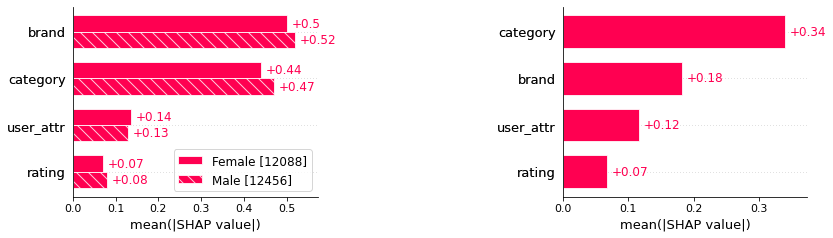

Affected Attribute Comparison
Average Comparison to True Class Members


Average Comparison to All Members


Random Affected Decision Process


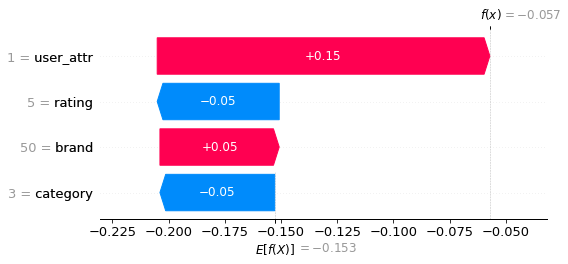

In [56]:
sensitive = 'user_attr' # sensible variable one wants to test for biases
labels = {0: 'Female',1: 'Male'} # 0 - Less than 2 kids and 1 - 2 or more kids
fd.understand_shap(X_test,y_test,model, labels,sensitive,1,0)